# 演習：線形モデル

この演習用Notebookでは、講義で扱った以下の時系列回帰の各モデル

- 線形回帰モデル
- ARXモデル
- L1正則化つきのARXモデル
- PLS回帰モデル

の学習と評価について、scikit-learnを利用した実装の一例を実行可能な形で掲載しています。時系列データを処理理する都合上、実装には多分に煩雑な部分も含まれますので必ずしもこの演習中に一行一行を全て理解する必要はありません。

演習用の時系列データとしては、他のNotebookと同様にETDataset（詳細は後述）を利用します。

## 準備

### Python及び各ライブラリの確認

このNotebookを実行する環境におけるPythonのバージョンは次のように確認できます。

In [67]:
from platform import python_version

print(f"Python version: {python_version()}")

Python version: 3.10.12


このNotebookのコードにはバージョン3.9以上のPython環境を前提にしている部分があります（主に[type hint](https://docs.python.org/ja/3/library/typing.html)関連）。条件を満たさない環境では正しく動作しない可能性がありますのでご注意ください。

このNotebookで利用する主なライブラリは

- pandas (`pandas`): https://pandas.pydata.org/
- scikit-learn (`sklearn`): https://scikit-learn.org/stable/index.html

の2つです。これらのバージョンは次のように確認できます。

In [68]:
import sklearn
import pandas as pd

In [69]:
print(f"scikit-learn version: {sklearn.__version__}")
print(f"pandas version: {pd.__version__}")

scikit-learn version: 1.2.2
pandas version: 1.5.3


### 使用するデータセットの確認

（関連する「ごちきか」記事：「[Electricity Transformer Temperature](https://gochikika.ntt.com/Datasets/ett.html)」）

このNotebookでは、オープンソースの[ETDataset](https://github.com/zhouhaoyi/ETDataset)の一部（ETTh1）を利用します。このデータセットはGitHubでCC-BY ND 4.0ライセンスの下に公開されており、適切な条件の下で自由に利用することができます。

以下のコードではGoogle Colabolatory環境での実行を前提に、データを `git clone` により仮想環境上にダウンロードしています。他の環境で実行する場合は、必要に応じて適切に書き換えてください。

In [70]:
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls ETDataset/ETT-small/

fatal: destination path 'ETDataset' already exists and is not an empty directory.
ETTh1.csv  ETTh2.csv  ETTm1.csv  ETTm2.csv


In [71]:
filepath = "ETDataset/ETT-small/ETTh1.csv"

ひとまずこのダウンロードしたcsvファイルをpandasで読み込んでみます。

In [72]:
df_raw = pd.read_csv(filepath)
df_raw.head()

date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000

データセットのdate列が日時を表しているようなので、この列をindexに設定することを考えます。

In [73]:
# check dtype of 'date' column
df_raw["date"].dtype

dtype('O')

このdate列は読み込み時にオブジェクト型（文字列など）として認識されているため、日時型に変換した上でindexに設定します。

In [74]:
df = df_raw.set_index("date")
df.index = pd.to_datetime(df.index)
df.head()

HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
date                                                                    
2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000

In [75]:
df.index

DatetimeIndex(['2016-07-01 00:00:00', '2016-07-01 01:00:00',
               '2016-07-01 02:00:00', '2016-07-01 03:00:00',
               '2016-07-01 04:00:00', '2016-07-01 05:00:00',
               '2016-07-01 06:00:00', '2016-07-01 07:00:00',
               '2016-07-01 08:00:00', '2016-07-01 09:00:00',
               ...
               '2018-06-26 10:00:00', '2018-06-26 11:00:00',
               '2018-06-26 12:00:00', '2018-06-26 13:00:00',
               '2018-06-26 14:00:00', '2018-06-26 15:00:00',
               '2018-06-26 16:00:00', '2018-06-26 17:00:00',
               '2018-06-26 18:00:00', '2018-06-26 19:00:00'],
              dtype='datetime64[ns]', name='date', length=17420, freq=None)

このindexの概要を確認したいのですが、index系統の型には `describe()` メソッドが存在しません。一度 `Series` 型に変換すれば `describe()` メソッドで概要を確認できます。

In [80]:
df.index.to_series().describe()

<ipython-input-80-4634fe0b7ace>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.index.to_series().describe()


count                   17420
unique                  17420
top       2016-07-01 00:00:00
freq                        1
first     2016-07-01 00:00:00
last      2018-06-26 19:00:00
Name: date, dtype: object

この内容からデータはおよそ2年分で、重複する時刻はないことがわかります。

本来は他にもデータの時刻が１時間おきであること、欠損した時刻がないことなども確認する必要がありますが、この演習では時間の都合により割愛します。

### データの整形と前準備

#### 目的変数・説明変数の設定

このNotebookでは、データセットのOT列の値をそれより前の時刻の各列の値から（同時刻の値を用いずに）予測する回帰問題を考えます。従って、目的変数（response variable）に対応する列はOTとなります。説明変数（explanatory variables）に対応する列は、


- 目的変数の過去の値（自己回帰項）を利用して良い場合は、OTを含む全てのカラム
- そうでない場合は、OT以外の全てのカラム

となります。

In [18]:
# response columns
resp_column = "OT"  # response column

# explanatory columns (LR-like case)
expl_columns = df.columns.to_list()
expl_columns.remove(resp_column)

# explanatory columns (ARX-like case)
all_columns = df.columns.to_list()

#### データの分割

（関連する「ごちきか」記事：「[クロスバリデーション（交差検証）](https://gochikika.ntt.com/Learning/cv.html)」）

学習を実行する前に、データセットを訓練用（training）・検証用（validation）・試験用（test）の3つに分割しておきます。これらの分割は、最も素朴な方法としては

- モデルや学習プロセスに調整すべきパラメータがある場合
  - パラメータの値ごとに訓練用のデータでモデルを訓練し、検証用のデータで結果を評価する
  - その中で、最も良い評価を得たパラメータの値を採用する
- そのようなパラメータがない場合や、パラメータの値を既に決定している場合
  - 訓練用と検証用をあわせたデータでモデルを訓練し、試験用のデータで結果を評価する

というように利用します。このような分割はscikit-learnだと `PredefinedSplit` （cf. [UserGuide](https://scikit-learn.org/stable/modules/cross_validation.html#predefined-split)）に対応するものです。


In [15]:
# split data into training, validation, and test
df_train = df[:"2017-06-30"]  # 12 months
df_valid = df["2017-07-01":"2017-12-31"]  # 6 months
df_test = df["2018-01-01":]  # 6 months

なお、pandasで日時に対応する値のsliceでデータを分割する場合、例えば上記の `df[:'2017-06-30']` のように指定すると2017年6月30日のデータまでが含まれることに注意が必要です。

In [16]:
df_train.tail()

HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
date                                                                    
2017-06-30 19:00:00  6.698 -0.469  4.015 -0.036  2.711 -0.670  15.547000
2017-06-30 20:00:00  7.033 -0.067  3.980  0.142  3.442 -0.670  17.305000
2017-06-30 21:00:00  6.631  0.000  3.696  0.249  2.894 -0.579  17.516001
2017-06-30 22:00:00  7.167  0.000  4.015  0.391  2.863 -0.579  17.868000
2017-06-30 23:00:00  8.707  1.474  5.863  1.173  2.589 -0.548  18.150000

#### データの正規化

（関連する「ごちきか」記事：「[正規化](https://gochikika.ntt.com/Preprocessing/normalization.html)」）

データのそれぞれの説明変数で値の分布が大きく異なる場合、多くのモデルや学習手法はその性能を発揮できません。それで多くの場合はそれぞれの説明変数の値の分布を近づけるような前処理が行われるのですが、そうした処理は総称して正規化（normalization）と呼ばれます。

実際、今回のデータについても以下のように各列で平均や標準偏差の値が大きく異なっていることが観察できます。

In [82]:
df_train.describe()

HUFL         HULL         MUFL         MULL         LUFL  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean      7.909795     2.019931     5.045573     0.763926     2.787863   
std       5.820496     2.080298     5.534967     1.922876     1.020194   
min     -18.754000    -3.416000   -21.285000    -4.762000    -1.188000   
25%       6.430000     0.335000     4.051000    -0.782000     2.132000   
50%       8.640000     1.875000     5.970000     0.853000     2.619000   
75%      11.186000     3.550000     8.209000     2.274000     3.259000   
max      23.643999     8.841000    17.341000     6.894000     7.889000   

              LULL           OT  
count  8760.000000  8760.000000  
mean      0.771786    17.169089  
std       0.642145     9.122925  
min      -1.371000    -4.080000  
25%       0.640000    10.130000  
50%       0.914000    15.898000  
75%       1.157000    21.737000  
max       3.046000    46.007000

今回は正規化の中でも各目的変数の分布の平均を0、分散を1にする標準化（standardization）という方法を用いますが、時系列データの正規化の方法については（同じ標準化でも）様々なものがあり、それぞれに細かい違いがあります。

このNotebookでは比較的素朴な方法として、

- まずモデルを訓練するデータの全体で各列ごとに標準化を行い、
- その後にラグ特徴量を生成して、いわゆる「窓枠処理」を行う

という方針を取ります。この方法は実装がそこまで煩雑ではありませんが、いわゆるlook-ahead biasの影響を排除しれきれていないことに留意しておく必要があります（時間の都合で詳細は省略）。

このNotebookでは、上記の標準化の処理を関数として実装し、後に利用します。一般的な標準化についてはscikit-learnに `StandardScaler` クラスとして実装されているので、このクラスを利用して実装します。以下の関数では、

- `scalers` 引数に `None` を渡したときには訓練用データから標準化のパラメータを計算した上でそのパラメータで標準化を行い、
- 同じく `StandardScaler` のタプルを渡したときには検証用・試験用データに既知の（訓練用データから計算した）パラメータで標準化を施す

ものとして実装しています。

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
def scale_timeseries(
    df_expl: pd.DataFrame,
    sr_resp: pd.Series,
    scalers: tuple[StandardScaler, StandardScaler] | None = None,
) -> tuple[pd.DataFrame, pd.Series, tuple[StandardScaler, StandardScaler]]:

    if scalers is None:
        # fit scalers to training data
        scaler_expl = StandardScaler().fit(df_expl)
        scaler_resp = StandardScaler().fit(sr_resp.to_numpy().reshape(-1, 1))
        return_scalers = (scaler_expl, scaler_resp)
    else:  # scalers: tuple[StandardScaler, StandardScaler]
        # no fitting (case for just scaling validation data)
        scaler_expl, scaler_resp = scalers
        return_scalers = scalers

    # scale data
    df_expl = pd.DataFrame(
        scaler_expl.transform(df_expl),
        index=df_expl.index,
        columns=df_expl.columns,
    )
    sr_resp = pd.Series(
        scaler_resp.transform(sr_resp.to_numpy().reshape(-1, 1)).flatten(),
        index=sr_resp.index,
        name=sr_resp.name,
    )

    return df_expl, sr_resp, return_scalers

#### 窓枠処理

（関連する「ごちきか」記事：「[時間窓切り出し処理](https://gochikika.ntt.com/Preprocessing/time-window.html)」）

講義でも扱ったように、時系列回帰モデルは例えば1時刻前から3時刻前までの値を使う場合は

y[t] = f ( x\_1[t-1], x\_1[t-2], x\_1[t-3], x\_2[t-1], x\_2[t-2], x\_2[t-3], ...,  x\_K[t-1], x\_K[t-2], x\_K[t-3] ) + e[t]

のような形をしています。こうしたモデルの学習をscikit-learnなどの必ずしも時系列データ向きでないライブラリで実現する場合、元の時系列データの

- 各行は現在の時刻: t, t+1, ...
- 各列は時系列データの特徴: x\_1, ..., x\_k

というK列の配列を、ラグ特徴量 L g(t) = g(t-1) を用いて

- 各行は現在の時刻: t, t+1, ...
- 各列は元の特徴のラグ特徴量: L x\_1, L^2 x\_1, L^3 x\_1, ..., L x\_K, L^2 x\_K, L^3 x\_K

という3K列の配列に変換してやる必要があります。この様な変換を「窓枠処理」などと呼ぶことがあります。

このNotebookでは、やはり上記の窓枠処理を関数として実装し、後に利用します。実装の方法はいくつもありますが、今回はpandasの `shift()` メソッド主に利用しています。

In [21]:
def lag_transform(
    df_expl: pd.DataFrame,
    sr_resp: pd.Series,
    max_lag: int,
) -> tuple[pd.DataFrame, pd.DataFrame]:

    # make lagged features
    df_x = pd.concat(
        [
            df_expl[column].shift(i).rename(column + f"_lag_{i}")
            for column in df_expl
            for i in range(1, max_lag + 1)
        ],
        axis=1,
    )
    df_x = df_x.iloc[max_lag:, :]  # drop records including nan

    sr_y = sr_resp.iloc[max_lag:]  # drop corresponding records

    return df_x, sr_y

この関数により、例えば次のように変換したDataFrameを生成することができます。

In [84]:
_df_x, _ = lag_transform(df_train[expl_columns], df_train[resp_column], max_lag=3)
_df_x.head()

HUFL_lag_1  HUFL_lag_2  HUFL_lag_3  HULL_lag_1  \
date                                                                  
2016-07-01 03:00:00       5.157       5.693       5.827       1.741   
2016-07-01 04:00:00       5.090       5.157       5.693       1.942   
2016-07-01 05:00:00       5.358       5.090       5.157       1.942   
2016-07-01 06:00:00       5.626       5.358       5.090       2.143   
2016-07-01 07:00:00       7.167       5.626       5.358       2.947   

                     HULL_lag_2  HULL_lag_3  MUFL_lag_1  MUFL_lag_2  \
date                                                                  
2016-07-01 03:00:00       2.076       2.009       1.279       1.492   
2016-07-01 04:00:00       1.741       2.076       1.279       1.279   
2016-07-01 05:00:00       1.942       1.741       1.492       1.279   
2016-07-01 06:00:00       1.942       1.942       1.528       1.492   
2016-07-01 07:00:00       2.143       1.942       2.132       1.528   

                     MUFL_lag_3  MULL_lag_1  MULL_lag_2  MULL_lag_3  \
date                                                                  
2016-07-01 03:00:00       1.599       0.355       0.426       0.462   
2016-07-01 04:00:00       1.492       0.391       0.355       0.426   
2016-07-01 05:00:00       1.279       0.462       0.391       0.355   
2016-07-01 06:00:00       1.279       0.533       0.462       0.391   
2016-07-01 07:00:00       1.492       0.782       0.533       0.462   

                     LUFL_lag_1  LUFL_lag_2  LUFL_lag_3  LULL_lag_1  \
date                                                                  
2016-07-01 03:00:00       3.777       4.142       4.203       1.218   
2016-07-01 04:00:00       3.807       3.777       4.142       1.279   
2016-07-01 05:00:00       3.868       3.807       3.777       1.279   
2016-07-01 06:00:00       4.051       3.868       3.807       1.371   
2016-07-01 07:00:00       5.026       4.051       3.868       1.858   

                     LULL_lag_2  LULL_lag_3  
date                                         
2016-07-01 03:00:00       1.371       1.340  
2016-07-01 04:00:00       1.218       1.371  
2016-07-01 05:00:00       1.279       1.218  
2016-07-01 06:00:00       1.279       1.279  
2016-07-01 07:00:00       1.371       1.279

このDataFrameの各列について、例えば `'HUFL_lag_2'` 列は元のDataFrameの `'HUFL'` 列の現在より2時刻前の値を格納しています。

#### 回帰モデルの評価関数の準備



（関連する「ごちきか」記事：「[回帰モデルの評価](https://gochikika.ntt.com/Learning/evaluation_regression.html)」）

今回のNotebookでは、回帰モデルの評価に二乗平均誤差（mean squared error; MSE）とR2を用います。MSEは正の値を取って小さいほど（0に近いほど）予測の結果がよく、R2は1以下の値を取って1に近いほど予測の結果がよいことを表す指標です。これらはいずれもscikit-learnに関数として実装されています。

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

## 基本的な線形モデル

（関連する「ごちきか」記事：「[基本的な回帰モデル](https://gochikika.ntt.com/Modeling/basic_regression_models.html)」）

まずは講義で扱った線形回帰モデルとARXモデルの実装を見ていきましょう。これらはいずれもscikit-learnの `LinearRegression` クラスを用いることで比較的簡単に実現できます。なお、これらのモデルは一般的な推定方法（OLS）を用いる限り、（計算の安定性を除いて）データの正規化の影響を受けません。

In [25]:
from sklearn.linear_model import LinearRegression

### 線形回帰モデル

線形回帰モデルは説明変数に自己回帰項を含まないモデルでした。まずはこの線形回帰モデルの学習における前処理、推定、結果の評価と可視化のプロセスを一つずつ追ってみましょう。

はじめにデータに「窓枠処理」を行い、ラグ特徴量を格納した配列に変換してやる必要があります。ここでは仮に窓幅（ラグ）の最大値を2と置いて変換を行ってみます。また、今のところは調整したいパラメータがないので、前述の通り

- 分割した訓練用と評価用のデータを用いてモデルの訓練を行い
- 試験用のデータを用いてモデルの評価を行う

ことにしてみます。

In [26]:
# lag transform
df_x_lag2_lr_train, sr_y_lag2_lr_train = lag_transform(
    df_expl=pd.concat([df_train[expl_columns], df_valid[expl_columns]]),
    sr_resp=pd.concat([df_train[resp_column], df_valid[resp_column]]),
    max_lag=2,
)
df_x_lag2_lr_test, sr_y_lag2_lr_test = lag_transform(
    df_expl=df_test[expl_columns],
    sr_resp=df_test[resp_column],
    max_lag=2,
)

次に、この変換したデータを `LinearRegression` クラスに学習（fit）させて線形回帰モデルのパラメータ推定を行います。また、この学習したモデルで訓練用・評価用のデータと試験用のデータのそれぞれについて目的変数の値を予測（predict）させておきます。

In [27]:
# fit and predict
lr = LinearRegression().fit(X=df_x_lag2_lr_train, y=sr_y_lag2_lr_train)
y_pred_lag2_lr_train = lr.predict(X=df_x_lag2_lr_train)
y_pred_lag2_lr_test = lr.predict(X=df_x_lag2_lr_test)

最後に、実際の目的変数の値と予測した値を比較します。まずはMSEとR2の評価指標を訓練に用いたデータ（訓練用・評価用）と評価に用いたデータ（試験用）のそれぞれについて計算します。

In [28]:
# compute scores
print(
    f"train MSE: {mean_squared_error(y_true=sr_y_lag2_lr_train, y_pred=y_pred_lag2_lr_train)}"
)
print(
    f"test MSE: {mean_squared_error(y_true=sr_y_lag2_lr_test, y_pred=y_pred_lag2_lr_test)}"
)
print(f"train R2: {r2_score(y_true=sr_y_lag2_lr_train, y_pred=y_pred_lag2_lr_train)}")
print(f"test R2: {r2_score(y_true=sr_y_lag2_lr_test, y_pred=y_pred_lag2_lr_test)}")

train MSE: 58.88747365292781
test MSE: 142.09728430491813
train R2: 0.20259289510116119
test R2: -8.426197593103792


これらの値、特に訓練に用いたデータに対するR2の値（train R2）を見るに、今回の設定では学習がうまく行っていないことが予想されます。

実際の値とモデルが予測した値をグラフにプロットして、状況を視覚的にも確認してみましょう。まず訓練に用いたデータについての比較は次の通りです。

<Axes: title={'center': 'true vs. pred (train-valid)'}, xlabel='date'>

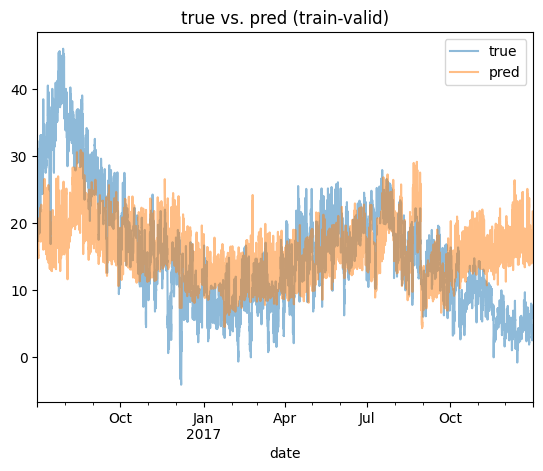

In [29]:
# plot graph (train-valid)
df_y_comparison_lr_train = pd.concat(
    [
        sr_y_lag2_lr_train.rename("true"),
        pd.Series(y_pred_lag2_lr_train, index=sr_y_lag2_lr_train.index, name="pred"),
    ],
    axis=1,
)
df_y_comparison_lr_train.plot(title="true vs. pred (train-valid)", alpha=0.5)

また、試験用のデータについての比較は次の通りです。

<Axes: title={'center': 'true vs. pred (test)'}, xlabel='date'>

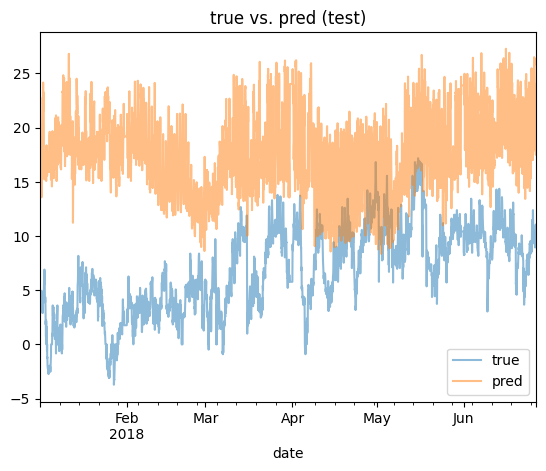

In [30]:
# plot graph (test)
df_y_comparison_lr_test = pd.concat(
    [
        sr_y_lag2_lr_test.rename("true"),
        pd.Series(y_pred_lag2_lr_test, index=sr_y_lag2_lr_test.index, name="pred"),
    ],
    axis=1,
)
df_y_comparison_lr_test.plot(title="true vs. pred (test)", alpha=0.5)

いずれも一見して実際の値（true）とモデルの予測した値（pred）が乖離しており、やはり学習がうまく行っていないことが確認できます。

#### 線形回帰モデルでの最適な窓幅の選択

これまで追ってきた線形回帰モデルの学習プロセスの中で、調整できるパラメータは「窓枠処理」の窓幅（引数 `max_lag` ）のみです。この値を適切に設定すれば線形回帰モデルの予測結果が改善するのかを確かめてみましょう。

前述の通り、このような調整すべきパラメータがあるときに検証（validation）用のデータを利用します。即ち、

- 窓幅の値ごとに訓練（training）用のデータを用いてモデルを学習し、検証（validation）用のデータで結果を評価する
- この中で評価指標の最も良かった窓幅の値を選択し、この窓幅の値で訓練・検証用のデータを用いて再度モデルを学習し、試験（test）用のデータで最終的な結果を評価する

という手続きを踏むことにします。

このような迂回的な方法を取るのは、今やっているような時系列回帰モデルの学習の目的として未知の、新しいデータに対する予測性能（汎化性能）を持ったモデルを獲得することを想定しているためです。試験（test）用のデータを用いた評価を未知のデータに対する評価の近似値として利用したいので、調整すべきパラメータの値を決定するために、いわばこうしたパラメータを「学習」するために試験用のデータを用いたくないのです。

時系列データだとこの処理はいささか煩雑になるのと、似たような処理を何度も繰り返すことになるのとで今回は関数として実装します。以下の関数は窓幅（ `max_lag` ）のパラメータに対するこうした結果の評価を格納したDataFrameを返すもので、それぞれの引数には

- `model`: 学習に利用するscikit-learnのモデル
- `df_train`: モデルを訓練するためのデータを格納したDataFrame
- `df_valid`: 学習結果を評価するためのデータを格納したDataFrame
- `expl_columns`: 説明変数として利用する列のリスト
- `resp_column`: 目的変数として設定する列
- `max_lag_upper_limitl`: 評価する窓幅の上限値
- `scaling`: データの標準化を行うか否か

を渡します。具体的な実装については、今回の演習中では読み飛ばして構いません。

In [31]:
from sklearn.base import BaseEstimator, clone

In [32]:
def validate_max_lag(
    model: BaseEstimator,
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    expl_columns: list[str],
    resp_column: str,
    max_lag_upper_limit: int,
    scaling: bool = False,
) -> pd.DataFrame:

    # make empty dataframe for validation result
    df_validation_result = pd.DataFrame(
        columns=["train_mse", "valid_mse", "train_r2", "valid_r2"],
    )
    df_validation_result.index.name = "max_lag"

    # slice dataset
    df_expl_train = df_train[expl_columns]
    sr_resp_train = df_train[resp_column]
    df_expl_valid = df_valid[expl_columns]
    sr_resp_valid = df_valid[resp_column]

    # scale dataset
    if scaling:
        df_expl_train, sr_resp_train, scalers = scale_timeseries(
            df_expl=df_train[expl_columns],
            sr_resp=df_train[resp_column],
            scalers=None,
        )
        df_expl_valid, sr_resp_valid, _ = scale_timeseries(
            df_expl=df_valid[expl_columns],
            sr_resp=df_valid[resp_column],
            scalers=scalers,
        )
    else:
        scalers = None

    for max_lag in range(1, max_lag_upper_limit + 1):
        # lag transform
        df_x_train, sr_y_train = lag_transform(
            df_expl=df_expl_train,
            sr_resp=sr_resp_train,
            max_lag=max_lag,
        )
        df_x_valid, sr_y_valid = lag_transform(
            df_expl=df_expl_valid,
            sr_resp=sr_resp_valid,
            max_lag=max_lag,
        )

        # fit and predict
        model_ = clone(model).fit(df_x_train, sr_y_train)
        y_pred_train = model_.predict(df_x_train).flatten()
        y_pred_valid = model_.predict(df_x_valid).flatten()

        # inverse-scale prediciton
        if scaling:  # scalers: tuple[StandardScaler, StandardScaler]
            _, scaler_resp = scalers
            resp_train = scaler_resp.inverse_transform(
                sr_y_train.to_numpy().reshape(-1, 1)
            ).flatten()
            resp_pred_train = scaler_resp.inverse_transform(
                y_pred_train.reshape(-1, 1)
            ).flatten()
            resp_valid = scaler_resp.inverse_transform(
                sr_y_valid.to_numpy().reshape(-1, 1)
            ).flatten()
            resp_pred_valid = scaler_resp.inverse_transform(
                y_pred_valid.reshape(-1, 1)
            ).flatten()
        else:
            resp_train = sr_y_train.to_numpy()
            resp_pred_train = y_pred_train
            resp_valid = sr_y_valid.to_numpy()
            resp_pred_valid = y_pred_valid

        # add to result
        df_validation_result.loc[max_lag] = [
            mean_squared_error(y_true=resp_train, y_pred=resp_pred_train),
            mean_squared_error(y_true=resp_valid, y_pred=resp_pred_valid),
            r2_score(y_true=resp_train, y_pred=resp_pred_train),
            r2_score(y_true=resp_valid, y_pred=resp_pred_valid),
        ]

    return df_validation_result

線形回帰モデルについて、窓幅の上限値を12としてこの関数によってそれぞれの窓幅の値を評価するには次の様にします。

In [33]:
df_lr_validation_result = validate_max_lag(
    model=LinearRegression(),
    df_train=df_train,
    df_valid=df_valid,
    expl_columns=expl_columns,
    resp_column=resp_column,
    max_lag_upper_limit=12,
)

評価の結果は次の通りです。関数の帰り値には、それぞれの窓幅（ `max_lag` ）ごとの訓練（training）用・評価（valid）用データに対するMSEとR2の値が格納されています。

In [34]:
df_lr_validation_result

train_mse   valid_mse  train_r2  valid_r2
max_lag                                           
1        49.595578  113.194067  0.403952 -2.014589
2        47.388322  115.680073  0.430456 -2.080636
3        45.711576  117.122225  0.450586 -2.119031
4        44.362655  118.329856  0.466814 -2.151133
5        43.027214  119.510690  0.482908 -2.182489
6        41.685566  120.781729  0.499077 -2.216326
7        40.573614  122.046151  0.512474 -2.250203
8        39.542037  123.339958  0.524900 -2.284867
9        38.468740  124.762839  0.537836 -2.323180
10       37.650733  125.819153  0.547715 -2.351055
11       36.910479  126.698730  0.556653 -2.373744
12       36.309167  127.590077  0.563920 -2.396755

やはり訓練用のデータに対するR2の値を見て、いずれの窓幅でも学習がうまくいっていなそうなことが予想できます。

とはいえこの中であえて最適な窓幅 `best_max_lag_lr` を選ぶとすれば、例えば評価用のデータに対するMSEの値を基準にする場合は次のように選択できます。

In [35]:
best_max_lag_lr = df_lr_validation_result["valid_mse"].idxmin()
best_max_lag_lr

1

この最適な窓幅の値を用いて、改めて訓練（training）用・評価（validation）用のデータの全体を用いて線形回帰モデルを学習し、試験（test）用のデータに対する評価を見てみましょう。こちらの処理も最初と似たようなものの繰り返しになり、また以降も同様の処理を何度も行うため関数にまとめてしまいます。

以下の関数で、引数の意味は先ほどの `validate_max_lag()` 関数とおよそ同じです。やはり具体的な実装は読み飛ばして構いません。

In [36]:
def train_model(
    model: BaseEstimator,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    expl_columns: list[str],
    resp_column: str,
    max_lag: int,
    scaling: bool = False,
) -> BaseEstimator:

    # slice dataset
    df_expl_train = df_train[expl_columns]
    sr_resp_train = df_train[resp_column]
    df_expl_test = df_test[expl_columns]
    sr_resp_test = df_test[resp_column]

    # scale dataset
    if scaling:
        df_expl_train, sr_resp_train, scalers = scale_timeseries(
            df_expl=df_train[expl_columns],
            sr_resp=df_train[resp_column],
            scalers=None,
        )
        df_expl_test, sr_resp_test, _ = scale_timeseries(
            df_expl=df_test[expl_columns],
            sr_resp=df_test[resp_column],
            scalers=scalers,
        )
    else:
        scalers = None

    # lag transform
    df_x_train, sr_y_train = lag_transform(
        df_expl=df_expl_train,
        sr_resp=sr_resp_train,
        max_lag=max_lag,
    )
    df_x_test, sr_y_test = lag_transform(
        df_expl=df_expl_test,
        sr_resp=sr_resp_test,
        max_lag=max_lag,
    )

    # fit and predict
    model_ = clone(model).fit(df_x_train, sr_y_train)
    y_pred_train = model_.predict(df_x_train).flatten()
    y_pred_test = model_.predict(df_x_test).flatten()

    # inverse-scale prediciton
    if scaling:  # scalers: tuple[StandardScaler, StandardScaler]
        _, scaler_resp = scalers
        resp_train = scaler_resp.inverse_transform(
            sr_y_train.to_numpy().reshape(-1, 1)
        ).flatten()
        resp_pred_train = scaler_resp.inverse_transform(
            y_pred_train.reshape(-1, 1)
        ).flatten()
        resp_test = scaler_resp.inverse_transform(
            sr_y_test.to_numpy().reshape(-1, 1)
        ).flatten()
        resp_pred_test = scaler_resp.inverse_transform(
            y_pred_test.reshape(-1, 1)
        ).flatten()
    else:
        resp_train = sr_y_train.to_numpy()
        resp_pred_train = y_pred_train
        resp_test = sr_y_test.to_numpy()
        resp_pred_test = y_pred_test

    # compute scores
    print(f"train MSE: {mean_squared_error(y_true=resp_train, y_pred=resp_pred_train)}")
    print(f"test MSE: {mean_squared_error(y_true=resp_test, y_pred=resp_pred_test)}")
    print(f"train R2: {r2_score(y_true=resp_train, y_pred=resp_pred_train)}")
    print(f"test R2: {r2_score(y_true=resp_test, y_pred=resp_pred_test)}")

    # plot graphs
    df_resp_comparison_train = pd.DataFrame(
        {
            "true": resp_train,
            "pred": resp_pred_train,
        },
        index=sr_y_train.index,
    )
    fig_train = df_resp_comparison_train.plot(
        title="true vs. pred (train-valid)", alpha=0.5
    )

    df_resp_comparison_test = pd.DataFrame(
        {
            "true": resp_test,
            "pred": resp_pred_test,
        },
        index=sr_y_test.index,
    )
    fig_test = df_resp_comparison_test.plot(title="true vs. pred (test)", alpha=0.5)

    return model_

では、実際にこの関数を実行してみましょう。　窓幅の引数 `max_lag` に先ほど選択した最適な窓幅 `best_max_lag_lr` を渡していることに注意してください。

train MSE: 60.04139256812512
test MSE: 138.69797039284347
train R2: 0.18703322711051173
test R2: -8.202129492117122


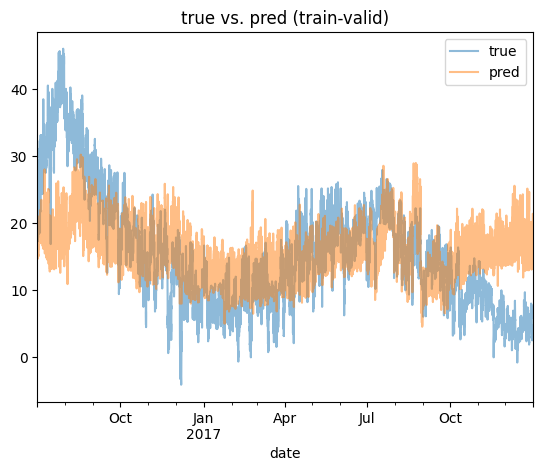

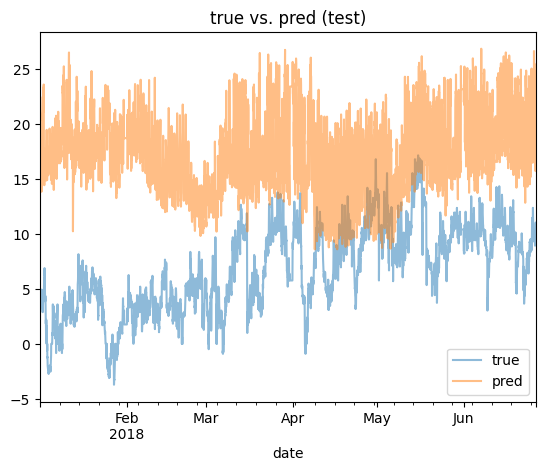

In [37]:
best_lr = train_model(
    model=LinearRegression(),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=expl_columns,
    resp_column=resp_column,
    max_lag=best_max_lag_lr,
)

たしかに試験用のデータに対する指標は最初の例よりも改善していますが、今回のデータについては、やはり線形回帰モデルでは最適な窓幅でも学習がうまくいかないようです。

### ARXモデル

ARXモデルは説明変数に自己回帰項を含むモデルでした。それ以外は線形回帰モデルと変わらないため、実装でも線形回帰モデルで `expl_columns` （目的変数以外の列のリスト）を渡していたところに `all_columns` （全ての列のリスト）を渡せば十分です。

ひとまず線形回帰モデルと同様、仮に窓幅（ラグ）の最大値を2と置いてモデルの学習と評価を行ってみましょう。線形回帰モデルのところで実装した関数が流用できるので、初めから `train_model()` 関数を用いて評価します。

train MSE: 0.9365901162015767
test MSE: 0.416669909734395
train R2: 0.9873174451762199
test R2: 0.97235969061992


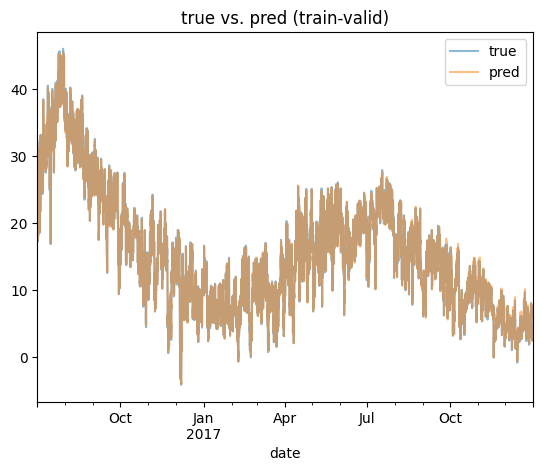

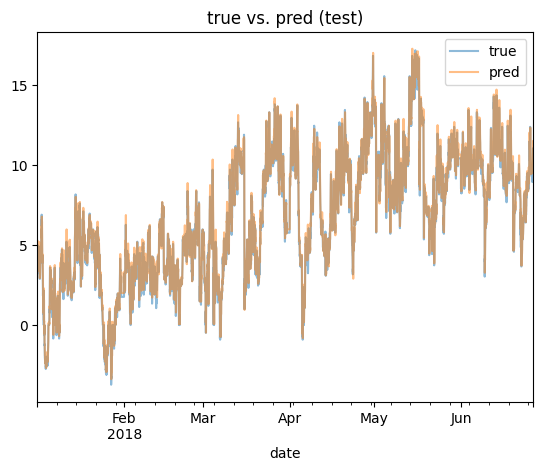

In [38]:
arx = train_model(
    model=LinearRegression(),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=2,
)

こちらは各種の指標を見ても、またグラフを視覚的に確認してみても明らかに線形回帰モデルと比べて学習がうまく行っているように見えます。

この結果に関する素朴な予想として、線形回帰モデルに追加した自己回帰項（過去の目的変数の値）が予測性能の向上に寄与していることが想像されます。先ほどの `train_model()` 関数は返り値として学習したモデルを出している（今回は `arx` に格納）ので、その各特徴量に対応する係数を確認してこの予想を検討してみましょう。

scikit-learnの `LinearRegression` クラスでは学習した係数が `coef_` 属性に格納されているので、これを対応するラグ特徴の名前とあわせて表示すると次のようになります。

In [40]:
_max_lag = 2
_lagged_index = [
    column + f"_lag_{i}" for column in all_columns for i in range(1, _max_lag + 1)
]

pd.Series(arx.coef_, index=_lagged_index)

HUFL_lag_1   -0.046165
HUFL_lag_2    0.055014
HULL_lag_1    0.134358
HULL_lag_2    0.165822
MUFL_lag_1   -0.005398
MUFL_lag_2   -0.026701
MULL_lag_1   -0.101702
MULL_lag_2   -0.160811
LUFL_lag_1   -0.012544
LUFL_lag_2    0.020997
LULL_lag_1    0.096296
LULL_lag_2   -0.388184
OT_lag_1      0.945567
OT_lag_2      0.044736
dtype: float64

係数の値のうち `'OT_lag_1'` （1時刻前の目的変数の値）に対応するものが1に近くなっていることが注目されます。直感的には、今回学習されたモデルは1時刻前の目的変数の値に他の説明変数の値（1時刻より前の目的変数の値を含む）で補正を加えたものを予測値としている、と解釈できるかもしれません。



#### ARXモデルでの最適な窓幅の選択

ARXモデルの学習プロセスの中においても、調整できるパラメータは「窓枠処理」の窓幅（引数 `max_lag` ）のみです。この値について、線形回帰モデルのときと同様に最適なものを選択してみましょう。

ここでも `validate_max_lag()` 関数を流用して評価が可能です。やはり線形回帰モデルでの `expl_columns` に代わって `all_columns` を関数に渡せば十分です。

In [41]:
df_arx_validation_result = validate_max_lag(
    model=LinearRegression(),
    df_train=df_train,
    df_valid=df_valid,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag_upper_limit=12,
)

In [42]:
df_arx_validation_result

train_mse  valid_mse  train_r2  valid_r2
max_lag                                          
1         1.101844   0.682693  0.986758  0.981818
2         1.085116   0.675671  0.986958  0.982006
3         1.078102   0.679052  0.987042  0.981916
4         1.074137   0.698036  0.987090  0.981411
5         1.069357   0.695383  0.987149  0.981482
6         1.062981   0.676652  0.987226  0.981981
7         1.060664   0.666564  0.987255  0.982249
8         1.057830   0.663458  0.987290  0.982330
9         1.054406   0.666483  0.987332  0.982248
10        1.049173   0.661920  0.987397  0.982370
11        1.045890   0.660357  0.987437  0.982416
12        1.042758   0.655241  0.987476  0.982556

In [43]:
best_max_lag_arx = df_arx_validation_result["valid_mse"].idxmin()
best_max_lag_arx

12

この最適な窓幅 `best_max_lag_arx` を用いて、 `train_model()` 関数でARXモデルを訓練・評価してみます。

train MSE: 0.9508570855095375
test MSE: 0.41730494441364363
train R2: 0.9871252950136241
test R2: 0.9723132636669554


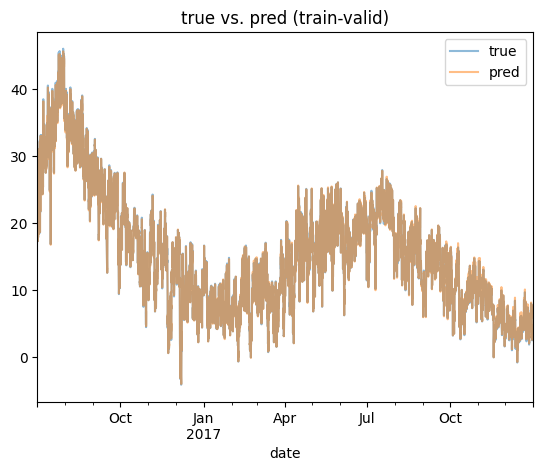

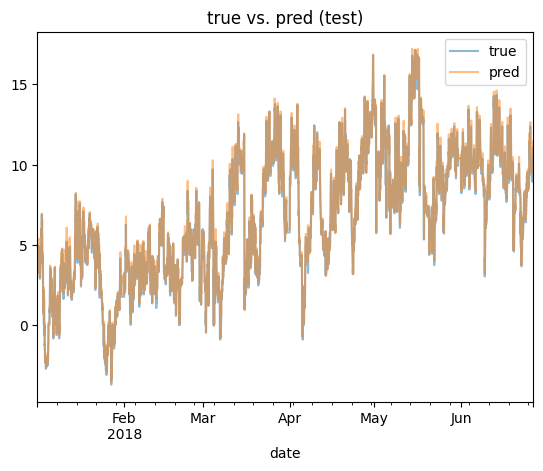

In [44]:
best_arx = train_model(
    model=LinearRegression(),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=best_max_lag_lr,
)

グラフ上での違いは分かりにくいものの、試験用データに対するMSEとR2の指標は改善していることが確認できます。

## 多重共線性の問題に対応した予測モデル

次に、講義で扱ったL1正則化つきの回帰モデルとPLS回帰モデルの時系列回帰における実装を見ていきましょう。これらはいずれも予測に利用する変数に制限のある類の手法ではないので、ARXモデルと同じ変数を用いた（即ち、説明変数として `all_columns` を指定した）場合の実装について見ていきます。

どちらの手法もscikit-learnに実装されているクラスを用いることで比較的簡単に実現できますが、これらは両方とも事前にデータの正則化を行うことが推奨されます。このNotebookでは、事前に関数を実装してある通りデータの標準化に基づいた正則化を適用して推論を行っていきます。

### L1正則化つきのARXモデル

（関連する「ごちきか」記事：「[スパースモデリング（基本編）](https://gochikika.ntt.com/Modeling/regularization.html)」）

今回のL1正則化を伴うモデリングはscikit-learnの `Lasso` クラスを利用して実装できます。やはり前段で実装した `train_model()` 関数が流用できますが、今回は学習の前にデータの標準化を行うので関数の引数に `scaling=True` を渡します。

`Lasso` の引数のうち正則化係数（の逆数）に対応するパラメータ `alpha` は本来データにあわせて適切に調整する必要のあるものです。ここではひとまず `alpha=0.1` を渡して実行してみます。また、 `train_model()` 関数に渡す窓幅の値についてもこれまで同様ひとまず `max_lag=2` と設定してみます。


In [45]:
from sklearn.linear_model import Lasso

train MSE: 1.716378462902009
test MSE: 1.390742043340888
train R2: 0.976758174597878
test R2: 0.9077434212364156


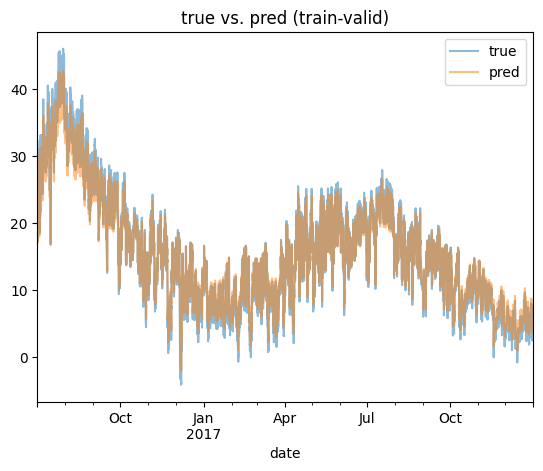

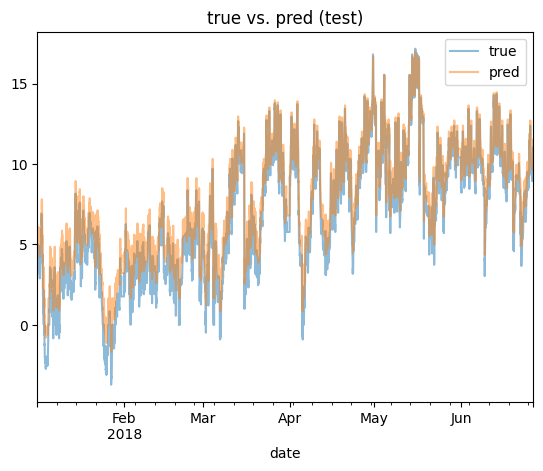

In [46]:
lasso = train_model(
    model=Lasso(alpha=0.1),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=2,
    scaling=True,
)

各種の指標、あるいはグラフから見ても明らかなように、訓練・検証用データに対しても試験用データに対しても素のARXモデルと比較して予測性能が悪化しました。

`Lasso` クラスのインスタンスでも学習した係数は `coef_` 属性に格納されているので、ARXモデルのときと同様に中身を確認してみましょう。

In [48]:
_max_lag = 2
_lagged_index = [
    column + f"_lag_{i}" for column in all_columns for i in range(1, _max_lag + 1)
]

pd.Series(lasso.coef_, index=_lagged_index)

HUFL_lag_1   -0.000000
HUFL_lag_2    0.000000
HULL_lag_1    0.000000
HULL_lag_2    0.000000
MUFL_lag_1   -0.000000
MUFL_lag_2   -0.000000
MULL_lag_1    0.000000
MULL_lag_2    0.000000
LUFL_lag_1    0.000000
LUFL_lag_2    0.000000
LULL_lag_1    0.000000
LULL_lag_2    0.000000
OT_lag_1      0.893324
OT_lag_2      0.000000
dtype: float64

このパラメータと窓枠では、 `'OT_lag_1'` （1時刻前の目的変数の値）に対応するもの以外の係数が全てほぼ0に縮小されてしまっています。このように、Lassoにおける `alpha` などの正則化に関するパラメータを不適切に設定してしまうと、モデルの係数の過度な縮小によりかえってモデルの予測性能が低下してしまう事態がしばしば発生します。こうした事態を回避するためにも、 `alpha` などのいわゆる「ハイパーパラメータ」はvalidationにより適切に選択される必要があるわけです。

#### L1正則化つきのARXモデルにおける最適なパラメータの選択

前段で実装した `validate_max_lag()` 関数は窓幅のvalidationを行うだけで、それ以外のハイパーパラメータのvalidationには対応していません。本来ならこうした状況ではscikit-learnのAPI群を駆使して相対的に簡潔な実装を目指す方がコードの保守性の観点からも上策です。

しかし、今回は演習ですので前段で実装した関数を改変してモデル `model` に渡すパラメータを1つだけ追加でvalidationできるようにした関数を実装してみます。


以下の関数 `validate_max_lag_and_model_param()` において新たに追加された引数には、

- `validating_parm`: `model` に渡すパラメータでvalidationを行いたいもの1つの名前と、対象となる値のリストとのタプル

の値を渡します。やはり細かい実装は読み飛ばしてもらっても構いませんが、時間が余っている場合はコードのどこが変更されたのかなどを探してみるのも面白いかもしれません。

In [49]:
def validate_max_lag_and_model_param(
    model: BaseEstimator,
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    expl_columns: list[str],
    resp_column: str,
    max_lag_upper_limit: int,
    validating_param: tuple[str, list],
    scaling: bool = False,
) -> pd.DataFrame:

    # make empty dataframe for validation result
    iterables = [range(1, max_lag_upper_limit + 1), validating_param[1]]
    df_validation_result = pd.DataFrame(
        index=pd.MultiIndex.from_product(
            iterables, names=["max_lag", validating_param[0]]
        ),
        columns=["train_mse", "valid_mse", "train_r2", "valid_r2"],
        dtype="float",
    )

    # slice dataset
    df_expl_train = df_train[expl_columns]
    sr_resp_train = df_train[resp_column]
    df_expl_valid = df_valid[expl_columns]
    sr_resp_valid = df_valid[resp_column]

    # scale dataset
    if scaling:
        df_expl_train, sr_resp_train, scalers = scale_timeseries(
            df_expl=df_train[expl_columns],
            sr_resp=df_train[resp_column],
            scalers=None,
        )
        df_expl_valid, sr_resp_valid, _ = scale_timeseries(
            df_expl=df_valid[expl_columns],
            sr_resp=df_valid[resp_column],
            scalers=scalers,
        )
    else:
        scalers = None

    for max_lag in range(1, max_lag_upper_limit + 1):
        # lag transform
        df_x_train, sr_y_train = lag_transform(
            df_expl=df_expl_train,
            sr_resp=sr_resp_train,
            max_lag=max_lag,
        )
        df_x_valid, sr_y_valid = lag_transform(
            df_expl=df_expl_valid,
            sr_resp=sr_resp_valid,
            max_lag=max_lag,
        )

        for value in validating_param[1]:
            # fit and predict
            model_ = clone(model).set_params(**{validating_param[0]: value})
            model_.fit(df_x_train, sr_y_train)
            y_pred_train = model_.predict(df_x_train).flatten()
            y_pred_valid = model_.predict(df_x_valid).flatten()

            # inverse-scale prediciton
            if scaling:  # scalers: tuple[StandardScaler, StandardScaler]
                _, scaler_resp = scalers
                resp_train = scaler_resp.inverse_transform(
                    sr_y_train.to_numpy().reshape(-1, 1)
                ).flatten()
                resp_pred_train = scaler_resp.inverse_transform(
                    y_pred_train.reshape(-1, 1)
                ).flatten()
                resp_valid = scaler_resp.inverse_transform(
                    sr_y_valid.to_numpy().reshape(-1, 1)
                ).flatten()
                resp_pred_valid = scaler_resp.inverse_transform(
                    y_pred_valid.reshape(-1, 1)
                ).flatten()
            else:
                resp_train = sr_y_train.to_numpy()
                resp_pred_train = y_pred_train
                resp_valid = sr_y_valid.to_numpy()
                resp_pred_valid = y_pred_valid

            # add to result
            df_validation_result.loc[(max_lag, value)] = [
                mean_squared_error(y_true=resp_train, y_pred=resp_pred_train),
                mean_squared_error(y_true=resp_valid, y_pred=resp_pred_valid),
                r2_score(y_true=resp_train, y_pred=resp_pred_train),
                r2_score(y_true=resp_valid, y_pred=resp_pred_valid),
            ]

    return df_validation_result

この新たに実装した関数を用いて、

- `Lasso` のパラメータ `alpha` については0.1, 0.01, 0.001の3つから選ぶ
- 窓幅は最大6までから選ぶ

という条件でvalidationを行った結果は次の通りとなります。

In [50]:
df_lasso_validation_result = validate_max_lag_and_model_param(
    model=Lasso(),
    df_train=df_train,
    df_valid=df_valid,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag_upper_limit=6,
    validating_param=("alpha", [0.1, 0.01, 0.001]),
    scaling=True,
)

In [51]:
df_lasso_validation_result

train_mse  valid_mse  train_r2  valid_r2
max_lag alpha                                          
1       0.100   1.970422   1.328859  0.976319  0.964610
        0.010   1.129549   0.672717  0.986425  0.982084
        0.001   1.103719   0.680385  0.986735  0.981880
2       0.100   1.969859   1.328779  0.976325  0.964614
        0.010   1.127298   0.676203  0.986451  0.981992
        0.001   1.095209   0.678589  0.986837  0.981929
3       0.100   1.970022   1.328884  0.976322  0.964611
        0.010   1.125166   0.679459  0.986476  0.981906
        0.001   1.087463   0.673516  0.986930  0.982064
4       0.100   1.969372   1.328929  0.976331  0.964611
        0.010   1.124433   0.679715  0.986486  0.981899
        0.001   1.085214   0.671176  0.986957  0.982127
5       0.100   1.968422   1.329046  0.976344  0.964608
        0.010   1.123429   0.679669  0.986499  0.981901
        0.001   1.081051   0.664335  0.987008  0.982309
6       0.100   1.968420   1.329170  0.976346  0.964605
        0.010   1.116690   0.665246  0.986581  0.982285
        0.001   1.074813   0.657536  0.987084  0.982490

やはり試験データに対するMSEの値を基準にとして、窓幅 `max_lag` とLassoのパラメータ `alpha` の組で最善のものは次のように求めることができます。

In [52]:
best_max_lag_and_lasso_param = df_lasso_validation_result["valid_mse"].idxmin()
best_max_lag_and_lasso_param

(6, 0.001)

この組の設定を用いてL1正則化つきのARXモデルを学習した結果は、やはり `train_model()` 関数を利用して次のようになります。

train MSE: 0.9240983413445095
test MSE: 0.409424347166041
train R2: 0.9874862772595245
test R2: 0.9728558495485543


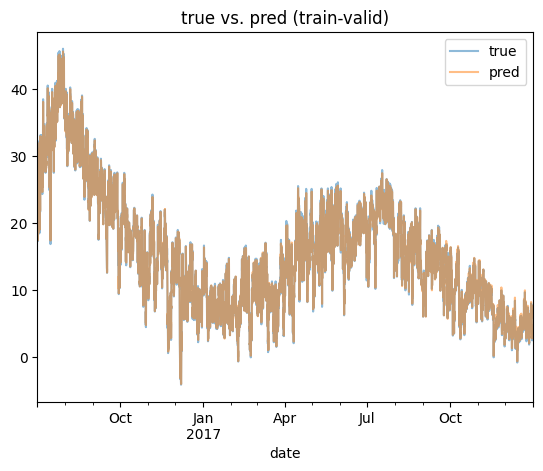

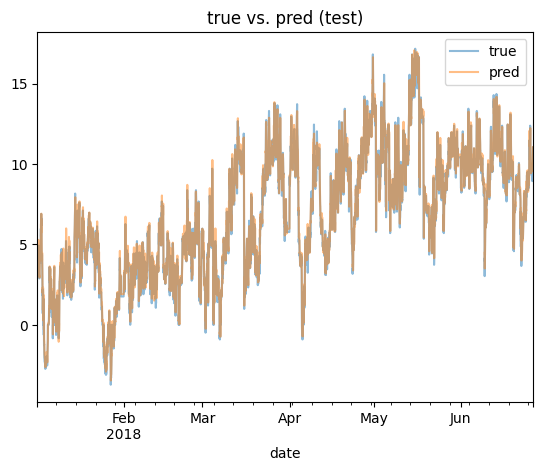

In [53]:
best_lasso = train_model(
    model=Lasso(alpha=best_max_lag_and_lasso_param[1]),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=best_max_lag_and_lasso_param[0],
    scaling=True,
)

今度は試験データに対する指標で正則化なしのARXモデルの結果にわずかながら優越することができました。

なお、この最適な設定のモデルで学習したL1正則化つきのARXモデルの係数は次のようになっています。

In [55]:
_max_lag = best_max_lag_and_lasso_param[0]
_lagged_index = [
    column + f"_lag_{i}" for column in all_columns for i in range(1, _max_lag + 1)
]

pd.Series(best_lasso.coef_, index=_lagged_index)

HUFL_lag_1   -0.000000
HUFL_lag_2   -0.000000
HUFL_lag_3    0.000000
HUFL_lag_4   -0.000000
HUFL_lag_5   -0.000000
HUFL_lag_6    0.007108
HULL_lag_1    0.000056
HULL_lag_2    0.001045
HULL_lag_3    0.006550
HULL_lag_4    0.000000
HULL_lag_5    0.000000
HULL_lag_6    0.000000
MUFL_lag_1   -0.021870
MUFL_lag_2   -0.000000
MUFL_lag_3   -0.000000
MUFL_lag_4   -0.000000
MUFL_lag_5   -0.000000
MUFL_lag_6    0.010314
MULL_lag_1    0.000000
MULL_lag_2    0.000000
MULL_lag_3    0.000000
MULL_lag_4   -0.000000
MULL_lag_5    0.000000
MULL_lag_6    0.000000
LUFL_lag_1    0.000000
LUFL_lag_2    0.000000
LUFL_lag_3    0.004399
LUFL_lag_4   -0.000000
LUFL_lag_5   -0.001928
LUFL_lag_6   -0.000000
LULL_lag_1   -0.000000
LULL_lag_2   -0.000000
LULL_lag_3   -0.000000
LULL_lag_4   -0.000112
LULL_lag_5   -0.000000
LULL_lag_6   -0.000315
OT_lag_1      0.939030
OT_lag_2      0.017266
OT_lag_3      0.001490
OT_lag_4      0.000000
OT_lag_5      0.013708
OT_lag_6      0.018957
dtype: float64

たしかに複数の係数の値が0に縮小されていることが確認できます。


### PLS回帰モデル

（関連する「ごちきか」記事：「[多重共線性に対応した回帰モデル](https://gochikika.ntt.com/Modeling/multicollinearity_regression.html)」）

PLS回帰はscikit-learnの `PLSRegression` クラスに実装されていますが、これはこれまでの 'linear_model' モジュールではなく 'cross_decomposition' モジュールに含まれています。このモデルでも前段で実装した `train_model()` 関数が流用できますが、やはり学習の前にデータの標準化を行う必要があるので関数の引数に `scaling=True` を渡します。

`PLSRegression` の引数のうち潜在空間の成分数 `n_comonents` がデータにあわせて適切に調整すべきパラメータです。ここではひとまず `n_components=3` を渡して実行してみます。また、 `train_model()` 関数に渡す窓幅の値についてもこれまで同様ひとまず `max_lag=2` と設定してみます。


In [56]:
from sklearn.cross_decomposition import PLSRegression

train MSE: 1.3321663925228218
test MSE: 0.6539035564261825
train R2: 0.9819608673897944
test R2: 0.9566225057723137


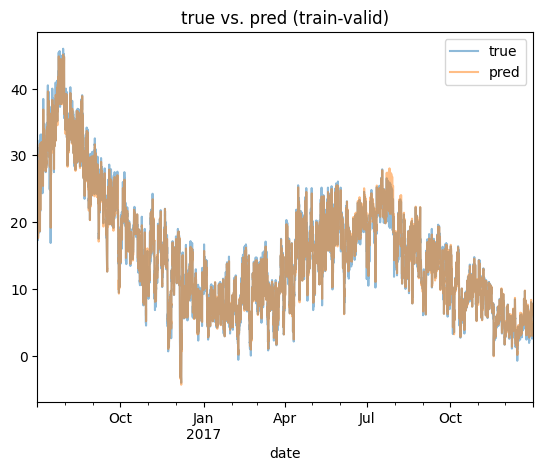

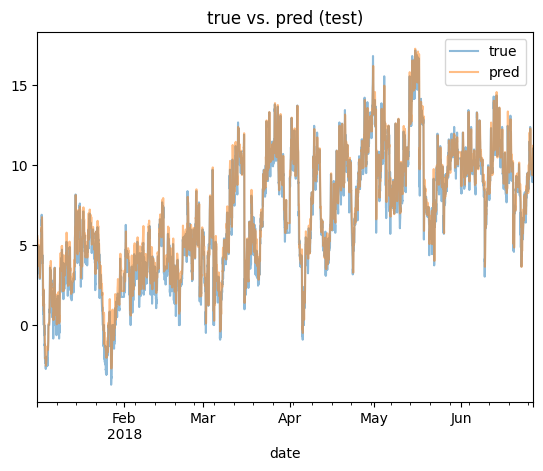

In [57]:
pls = train_model(
    model=PLSRegression(n_components=3),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=2,
    scaling=True,
)

やはり特に理由なく設定した窓枠の幅とパラメータの組では素のARXの予測性能より悪くなってしまいます。

#### PLS回帰における最適なパラメータの選択

再び先ほど実装した `validate_max_lag_and_model_param()` 関数を使って、窓枠 `max_lag` とPLS回帰のパラメータ `n_components` の組の中で最適なものを探索してみましょう。今回も探索する窓幅の最大値は6とし、PLS回帰の成分数の探索範囲は3から5の間と設定してみます。

In [58]:
df_pls_validation_result = validate_max_lag_and_model_param(
    model=PLSRegression(),
    df_train=df_train,
    df_valid=df_valid,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag_upper_limit=6,
    validating_param=("n_components", [3, 4, 5]),
)

In [59]:
df_pls_validation_result

train_mse  valid_mse  train_r2  valid_r2
max_lag n_components                                          
1       3              1.233015   1.094428  0.985181  0.970853
        4              1.116682   0.726901  0.986580  0.980641
        5              1.104522   0.688618  0.986726  0.981661
2       3              1.514439   1.551456  0.981798  0.958684
        4              1.369772   0.974702  0.983537  0.974043
        5              1.338828   0.873107  0.983909  0.976749
3       3              1.864070   2.099407  0.977595  0.944092
        4              1.685838   1.265566  0.979738  0.966297
        5              1.614481   1.045709  0.980595  0.972152
4       3              2.239745   2.650926  0.973081  0.929406
        4              2.013869   1.499840  0.975796  0.960059
        5              1.882378   1.158004  0.977376  0.969162
5       3              2.580645   3.141546  0.968986  0.916343
        4              2.291121   1.623459  0.972466  0.956768
        5              2.112888   1.259275  0.974608  0.966466
6       3              2.868909   3.526093  0.965525  0.906103
        4              2.510160   1.666044  0.969836  0.955635
        5              2.319137   1.389164  0.972132  0.963008

試験データに対するMSEの観点から、最適な窓幅とPLS回帰の成分数との組は次の通りです。

In [60]:
best_max_lag_and_pls_param = df_pls_validation_result["valid_mse"].idxmin()
best_max_lag_and_pls_param

(1, 5)

この組の設定で `train_model()` 関数を用いてモデルを学習してみましょう。

train MSE: 0.9240983413445095
test MSE: 0.409424347166041
train R2: 0.9874862772595245
test R2: 0.9728558495485543


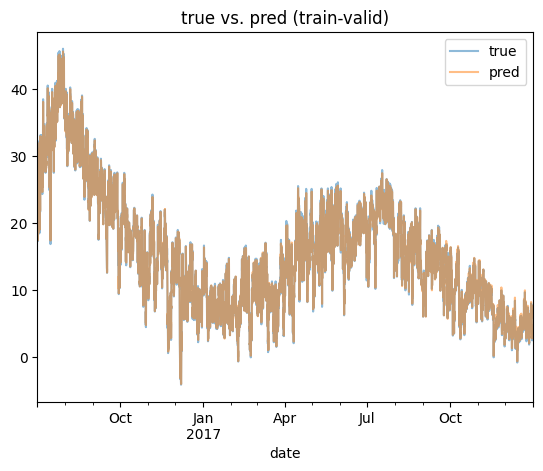

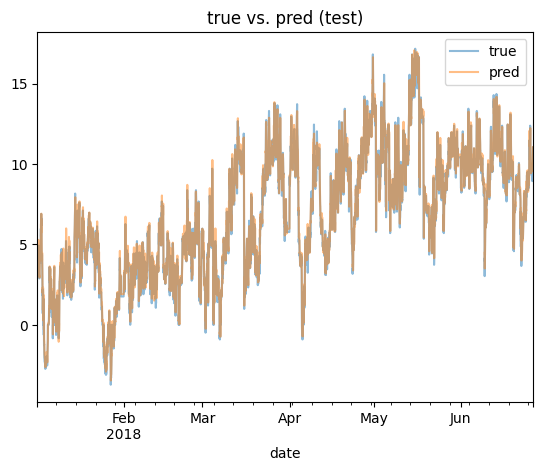

In [62]:
best_pls = train_model(
    model=Lasso(alpha=best_max_lag_and_lasso_param[1]),
    df_train=pd.concat([df_train, df_valid]),
    df_test=df_test,
    expl_columns=all_columns,
    resp_column=resp_column,
    max_lag=best_max_lag_and_lasso_param[0],
    scaling=True,
)

この組の設定で学習したPLS回帰のモデルでは、ARXモデルでの最善な結果に優越することができました。